# Planet: Understanding the Amazon deforestation from Space challenge

Special thanks to the kernel contributors of this challenge (especially @anokas and @Kaggoo) who helped me find a starting point for this notebook.

The whole code including the `data_helper.py` and `keras_helper.py` files are available on github [here](https://github.com/EKami/planet-amazon-deforestation) and the notebook can be found on the same github [here](https://github.com/EKami/planet-amazon-deforestation/blob/master/notebooks/amazon_forest_notebook.ipynb)

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('../src')
sys.path.append('../tests')

## Import required modules

In [2]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import data_helper
from keras_helper import AmazonKerasClassifier
from kaggle_data.downloader import KaggleDataDownloader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Print tensorflow version for reuse (the Keras module is used directly from the tensorflow framework)

In [3]:
tf.__version__

'1.1.0'

## Download the competition files
Download the dataset files and extract them automatically with the help of [Kaggle data downloader](https://github.com/EKami/kaggle-data-downloader)

In [4]:
competition_name = "planet-understanding-the-amazon-from-space"

train, train_u = "train-jpg.tar.7z", "train-jpg.tar"
test, test_u = "test-jpg.tar.7z", "test-jpg.tar"
test_additional, test_additional_u = "test-jpg-additional.tar.7z", "test-jpg-additional.tar"
test_labels = "train_v2.csv.zip"
destination_path = "../input/"
is_datasets_present = False

# If the folders already exists then the files may already be extracted
# This is a bit hacky but it's sufficient for our needs
datasets_path = data_helper.get_jpeg_data_files_paths()
for dir_path in datasets_path:
    if os.path.exists(dir_path):
        is_datasets_present = True

if not is_datasets_present:
    # Put your Kaggle user name and password in a $KAGGLE_USER and $KAGGLE_PASSWD env vars respectively
    downloader = KaggleDataDownloader(os.getenv("KAGGLE_USER"), os.getenv("KAGGLE_PASSWD"), competition_name)
    
    train_output_path = downloader.download_dataset(train, destination_path)
    downloader.decompress(train_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + train_u, destination_path) # Extract the content of the previous tar file
    os.remove(train_output_path) # Removes the 7z file
    os.remove(destination_path + train_u) # Removes the tar file
    
    test_output_path = downloader.download_dataset(test, destination_path)
    downloader.decompress(test_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + test_u, destination_path) # Extract the content of the previous tar file
    os.remove(test_output_path) # Removes the 7z file
    os.remove(destination_path + test_u) # Removes the tar file
    
    test_add_output_path = downloader.download_dataset(test_additional, destination_path)
    downloader.decompress(test_add_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + test_additional_u, destination_path) # Extract the content of the previous tar file
    os.remove(test_add_output_path) # Removes the 7z file
    os.remove(destination_path + test_additional_u) # Removes the tar file
    
    test_labels_output_path = downloader.download_dataset(test_labels, destination_path)
    downloader.decompress(test_labels_output_path, destination_path) # Outputs a csv file
    os.remove(test_labels_output_path) # Removes the zip file
else:
    print("All datasets are present.")

All datasets are present.


## Inspect image labels
Visualize what the training set looks like

In [5]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [6]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'primary', 'cultivation', 'bare_ground', 'blooming', 'slash_burn', 'haze', 'conventional_mine', 'artisinal_mine', 'habitation', 'clear', 'road', 'selective_logging', 'blow_down', 'water', 'partly_cloudy', 'cloudy', 'agriculture'}


### Repartition of each labels

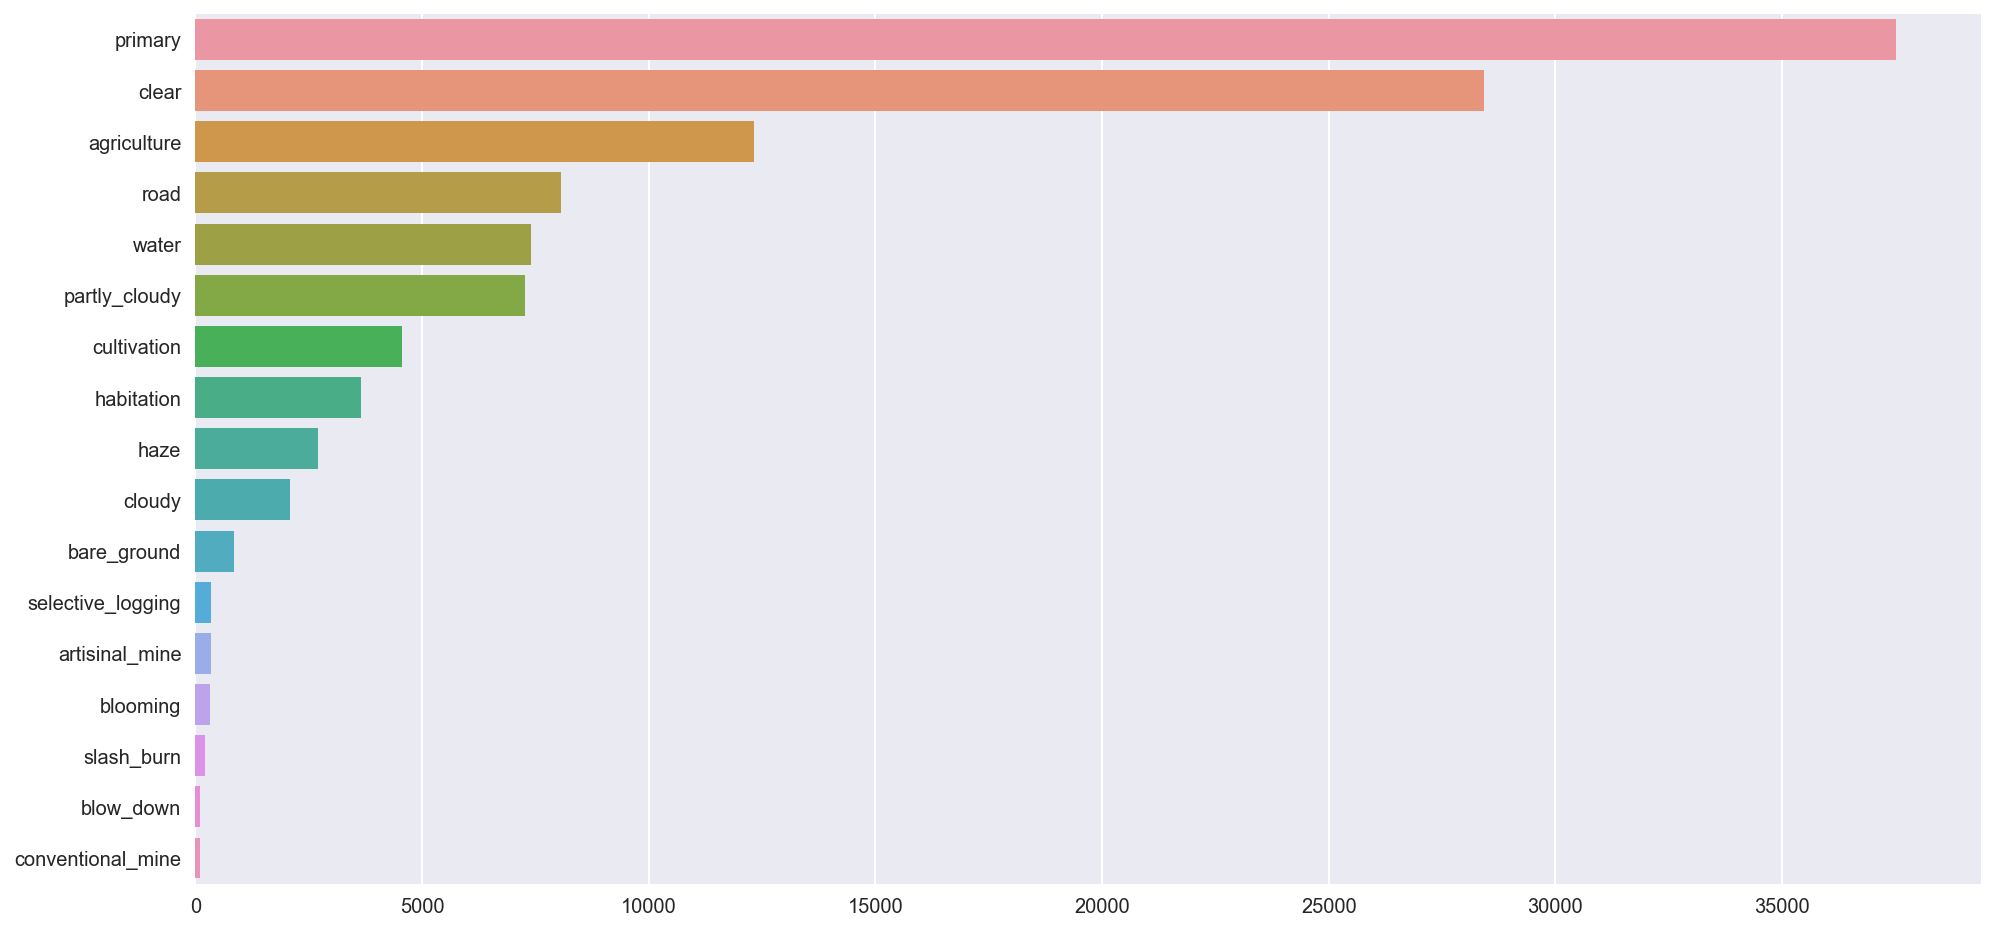

In [7]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

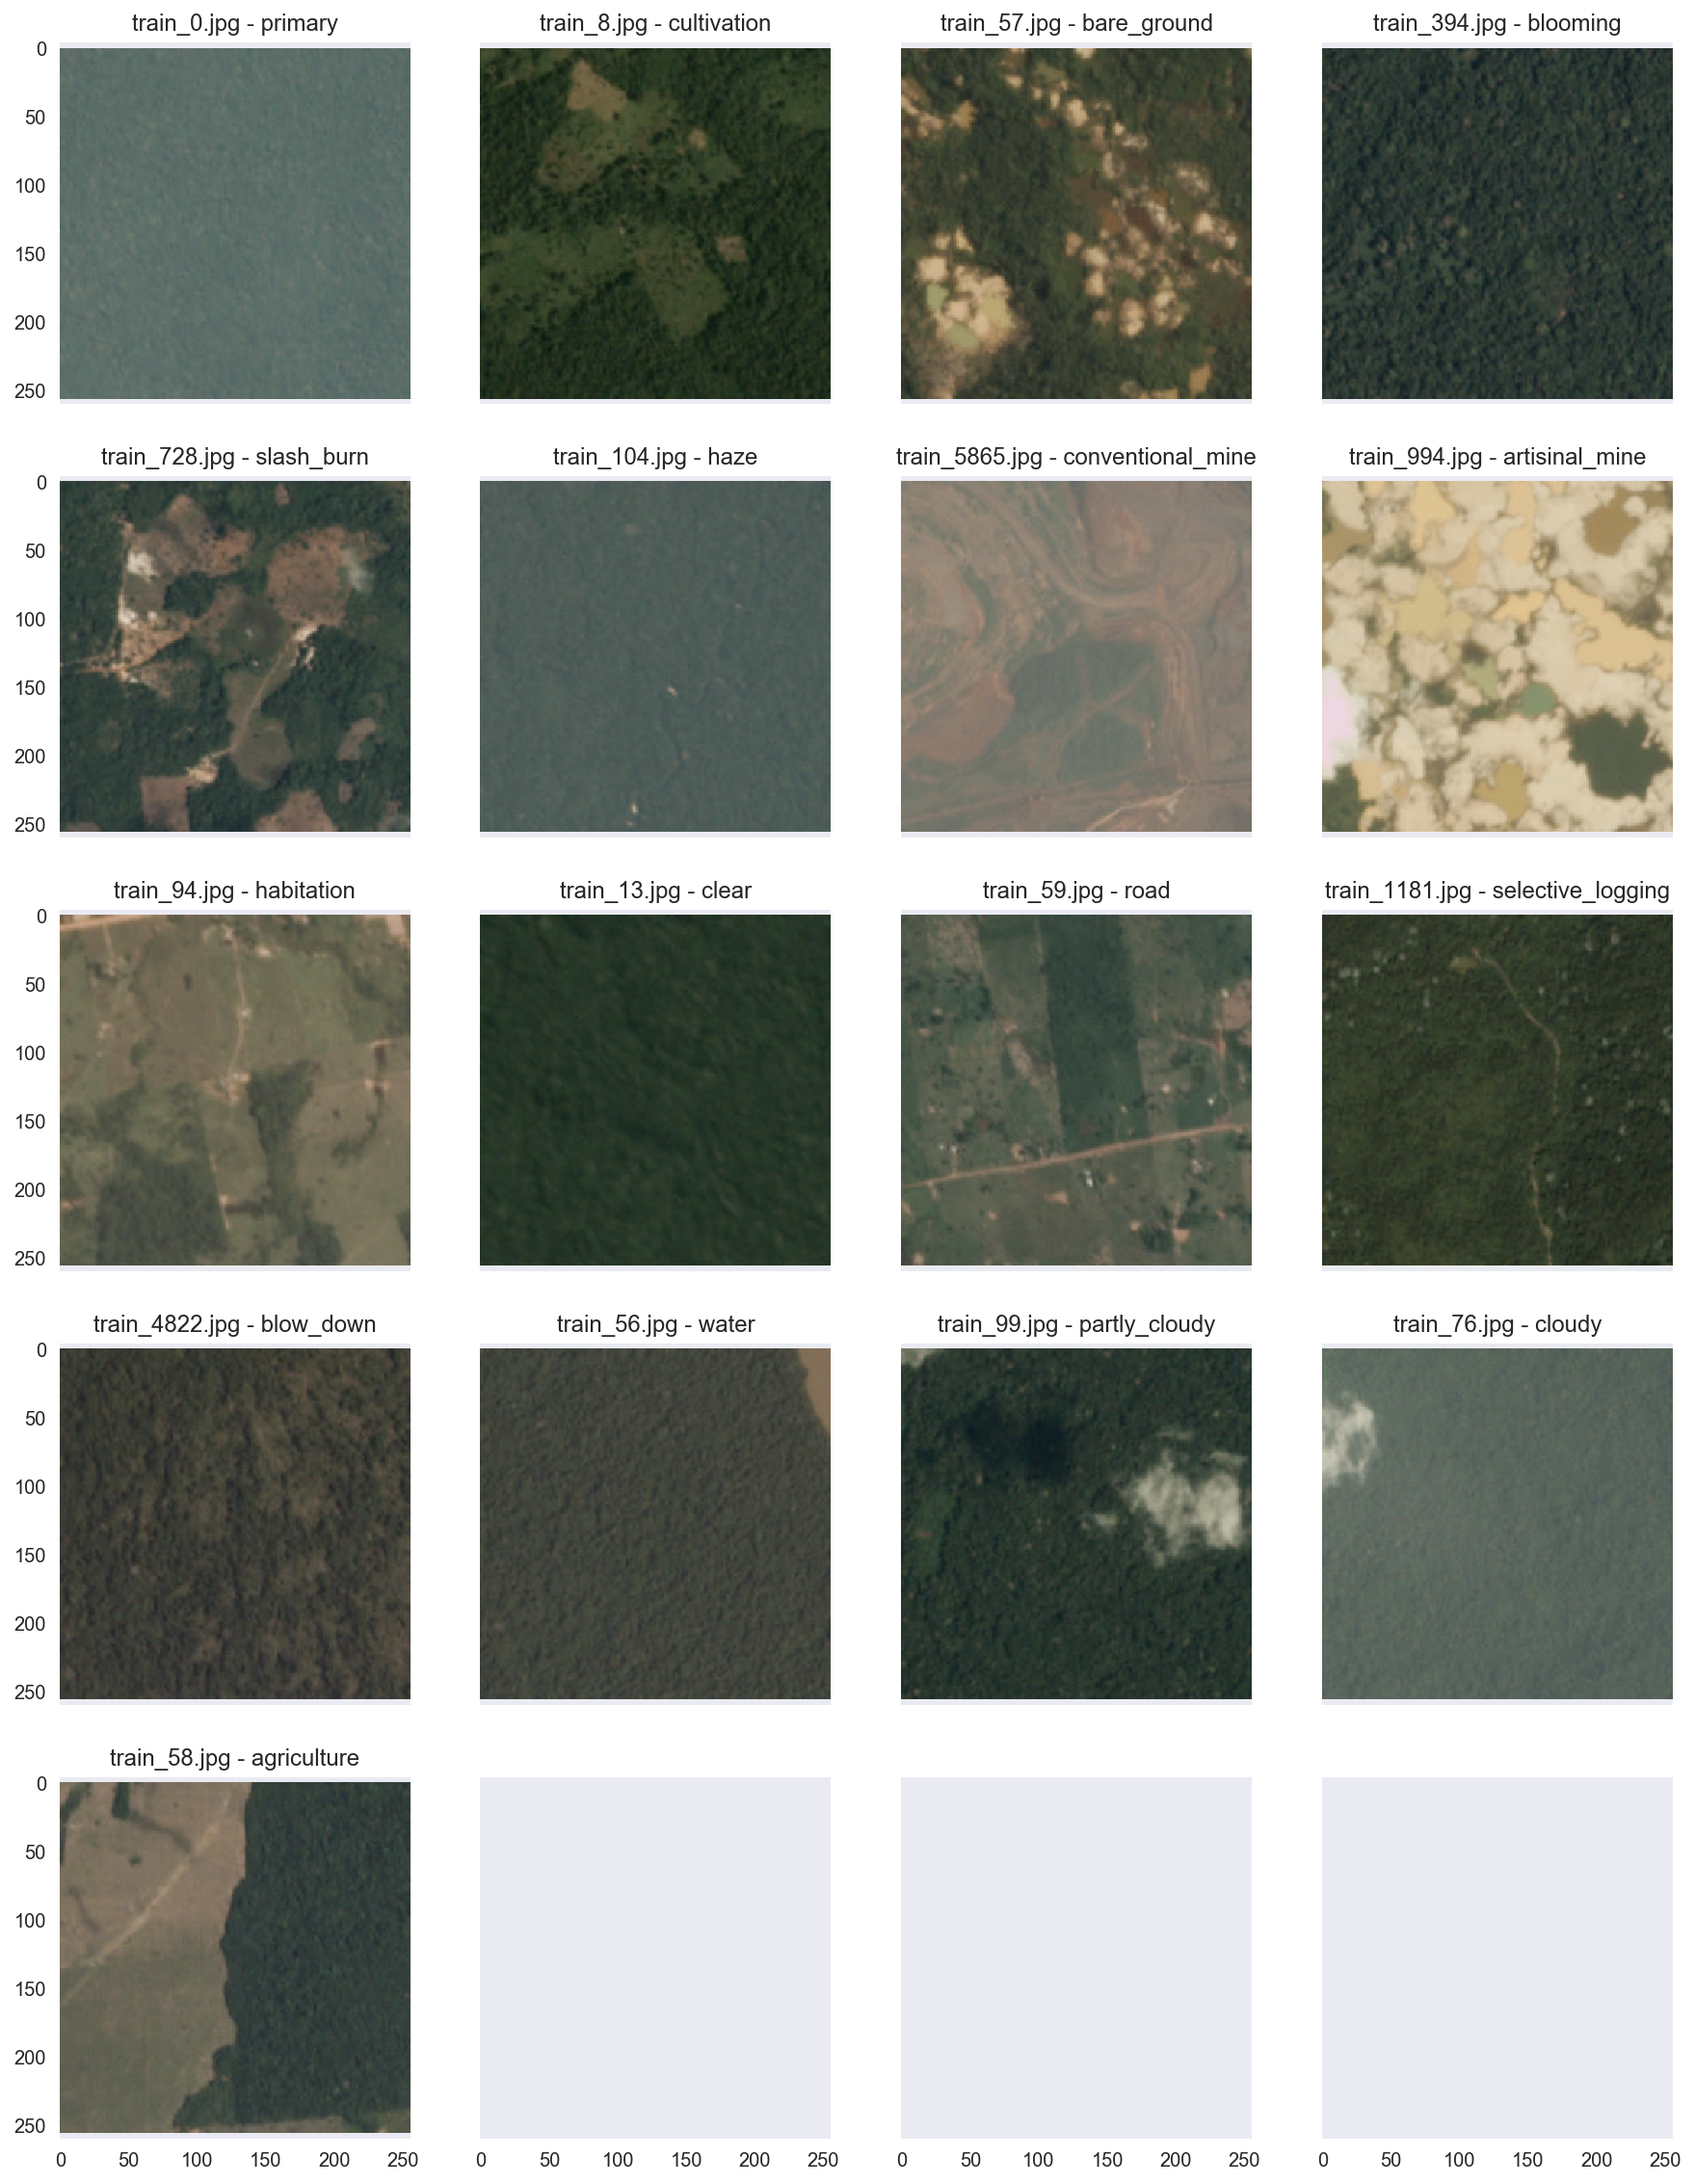

In [8]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

# Define hyperparameters
Define the hyperparameters of our neural network

In [9]:
img_resize = (64, 64) # The resize size of each image
validation_split_size = 0.2
batch_size = 128

# Data preprocessing
Preprocess the data in order to fit it into the Keras model.

Due to the hudge amount of memory the resulting matrices will take, the preprocessing will be splitted into several steps:
    - Preprocess training data (images and labels) and train the neural net with it
    - Delete the training data and call the gc to free up memory
    - Preprocess the first testing set
    - Predict the first testing set labels
    - Delete the first testing set
    - Preprocess the second testing set
    - Predict the second testing set labels and append them to the first testing set
    - Delete the second testing set

In [10]:
x_train, y_train, y_map = data_helper.preprocess_train_data(train_jpeg_dir, train_csv_file, img_resize)
# Free up all available memory space after this heavy operation
gc.collect();

100%|██████████| 40479/40479 [00:07<00:00, 5115.92it/s]


Done. Size consumed by arrays 1898.1093893051147 mb


In [11]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
y_map

x_train shape: (40479, 64, 64, 3)
y_train shape: (40479, 17)


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

## Create a checkpoint

Creating a checkpoint saves the best model weights across all epochs in the training process. This ensures that we will always use only the best weights when making our predictions on the test set rather than using the default which takes the final score from the last epoch. 

In [12]:
from tensorflow.contrib.keras.api.keras.callbacks import ModelCheckpoint

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Using TensorFlow backend.


## Create the neural network definition

In [13]:
epochs = 20
learn_rate = 0.001

classifier = AmazonKerasClassifier()
classifier.add_conv_layer(img_resize)
classifier.add_flatten_layer()
classifier.add_ann_layer(len(y_map))
train_losses, val_losses, fbeta_score = classifier.train_model(x_train, y_train, learn_rate, epochs, batch_size, validation_split_size=validation_split_size, train_callbacks=[checkpoint])

Train on 32383 samples, validate on 8096 samples
Epoch 1/20
32383/32383 [==============================] - 9s - loss: 0.2367 - acc: 0.9097 - val_loss: 0.2151 - val_acc: 0.9185
Epoch 2/20
32383/32383 [==============================] - 8s - loss: 0.1893 - acc: 0.9268 - val_loss: 0.1727 - val_acc: 0.9336
Epoch 3/20
32383/32383 [==============================] - 8s - loss: 0.1703 - acc: 0.9337 - val_loss: 0.1540 - val_acc: 0.9394
Epoch 4/20
32383/32383 [==============================] - 8s - loss: 0.1612 - acc: 0.9371 - val_loss: 0.1480 - val_acc: 0.9406
Epoch 5/20
32383/32383 [==============================] - 8s - loss: 0.1554 - acc: 0.9388 - val_loss: 0.1450 - val_acc: 0.9424
Epoch 6/20
32383/32383 [==============================] - 8s - loss: 0.1515 - acc: 0.9405 - val_loss: 0.1433 - val_acc: 0.9425
Epoch 7/20
32383/32383 [==============================] - 8s - loss: 0.1475 - acc: 0.9421 - val_loss: 0.1369 - val_acc: 0.9457
Epoch 8/20
32383/32383 [==============================] - 8s -

## Continue Training

Here you can continue training the model for additional epochs with the option to adjust the learning rate. 

If you are finished training you can skip this step.

In [ ]:
epochs = 5
learn_rate = 0.001
train_losses, val_losses, fbeta_score = classifier.train_model(x_train, y_train, learn_rate, epochs, batch_size, validation_split_size=validation_split_size, train_callbacks=[checkpoint])

## Load Best Weights

Here you should load back in the best weights that were automatically saved by ModelCheckpoint during training

In [14]:
classifier.load_weights("weights.best.hdf5")
print("Weights loaded")

## Monitor the results

Check that we do not overfit by plotting the losses of the train and validation sets

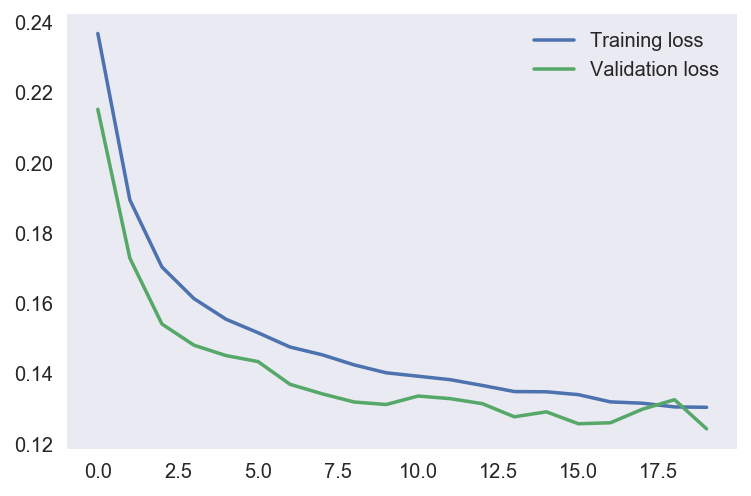

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend();

Look at our fbeta_score

In [16]:
fbeta_score

0.88967298663005845

Before launching our predictions lets preprocess the test data and delete the old training data matrices

In [17]:
del x_train, y_train
gc.collect()

x_test, x_test_filename = data_helper.preprocess_test_data(test_jpeg_dir, img_resize)
# Predict the labels of our x_test images
predictions = classifier.predict(x_test)

100%|██████████| 40669/40669 [00:07<00:00, 5186.32it/s]


Done. Size consumed by arrays 1906.359375 mb


Now lets launch the predictions on the additionnal dataset (updated on 05/05/2017 on Kaggle)

In [18]:
del x_test
gc.collect()

x_test, x_test_filename_additional = data_helper.preprocess_test_data(test_jpeg_additional, img_resize)
new_predictions = classifier.predict(x_test)

del x_test
gc.collect()
predictions = np.vstack((predictions, new_predictions))
x_test_filename = np.hstack((x_test_filename, x_test_filename_additional))
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              predictions[0]))

100%|██████████| 20522/20522 [00:03<00:00, 5289.39it/s]


Done. Size consumed by arrays 961.96875 mb
Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions entry:
[  8.95541489e-01   8.63106863e-04   3.52440514e-02   1.43566591e-04
   1.02570122e-02   1.77670701e-03   1.50924447e-04   2.76919384e-03
   4.06190217e-01   1.70314461e-01   1.05628613e-04   9.97265577e-01
   9.98043656e-01   4.15829569e-01   7.19845574e-03   4.08770852e-02
   1.69300288e-01]


Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class.

To do so we will take the median value of each classes.

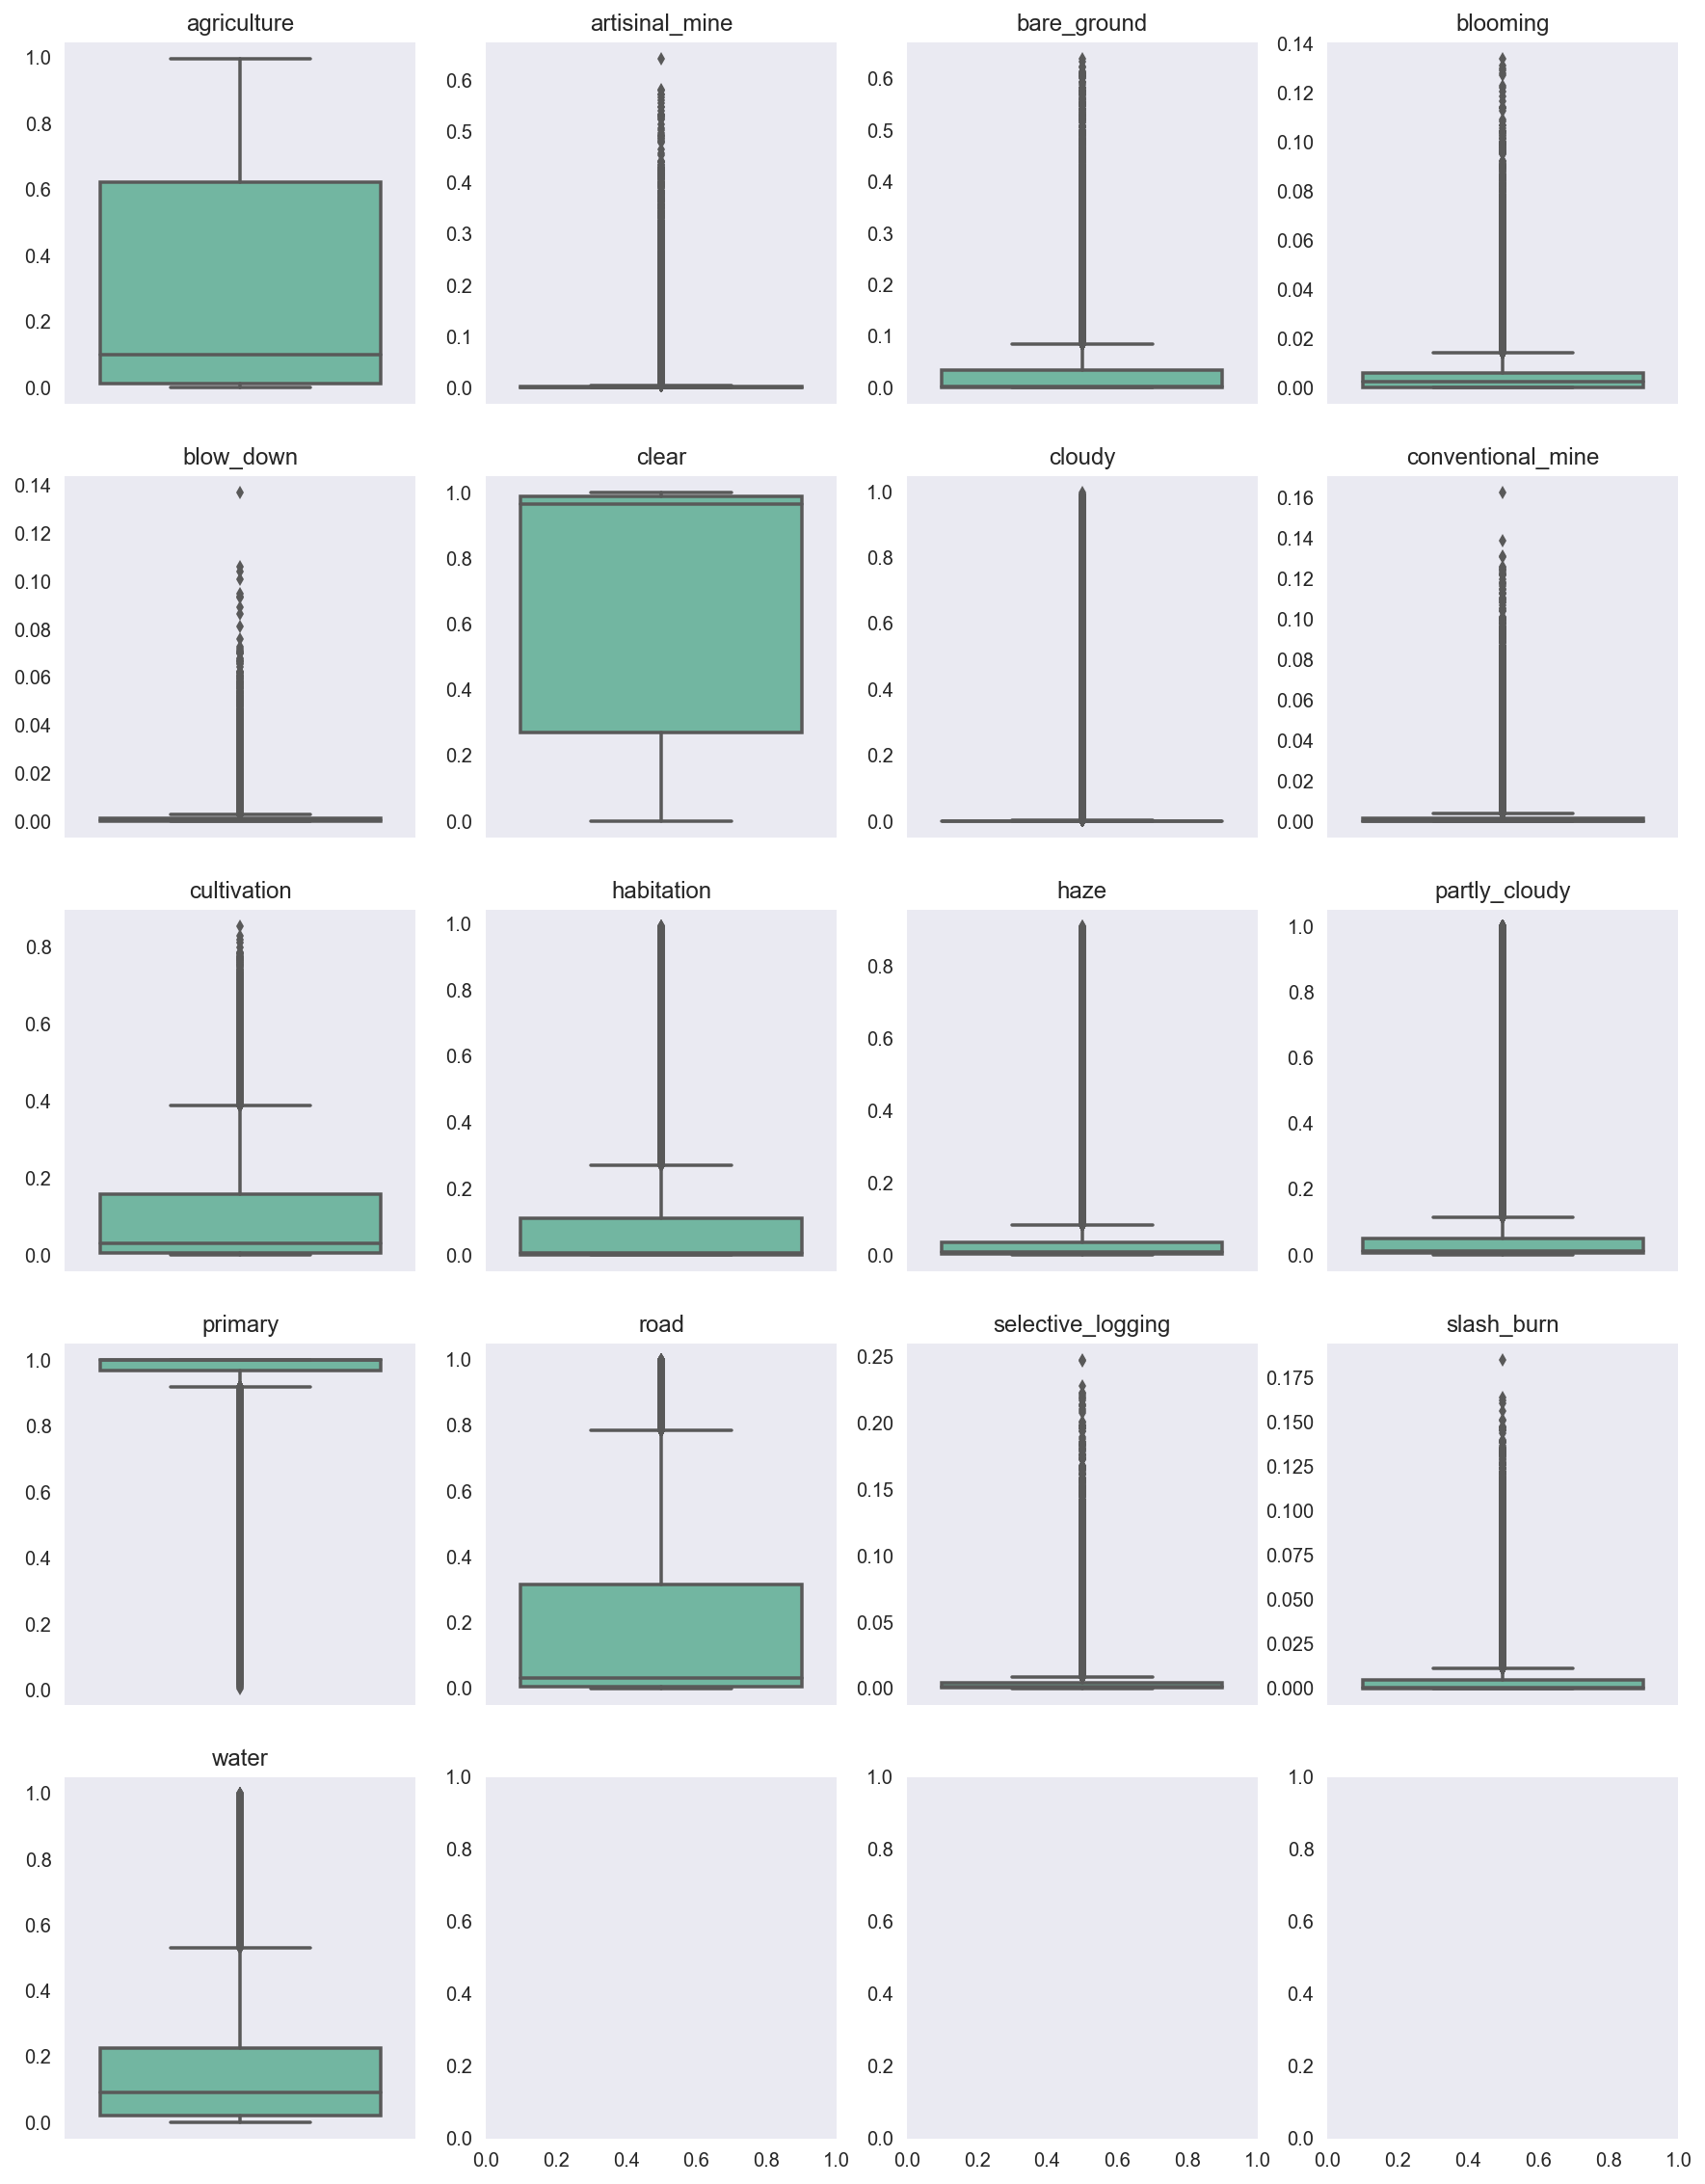

In [19]:
# For now we'll just put all thresholds to 0.2 
thresholds = [0.2] * len(labels_set)

# TODO complete
tags_pred = np.array(predictions).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(y_map[i])

Now lets map our predictions to their tags and use the thresholds we just retrieved

In [20]:
predicted_labels = classifier.map_predictions(predictions, y_map, thresholds)

Finally lets assemble and visualize our prediction for the test dataset

In [21]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [22]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
final_df.head()

,image_name,tags
0,test_7329,agriculture cultivation partly_cloudy primary ...
1,test_10598,agriculture clear primary road water
2,test_3192,clear primary
3,test_23467,agriculture clear cultivation habitation prima...
4,test_6967,agriculture artisinal_mine clear cultivation h...


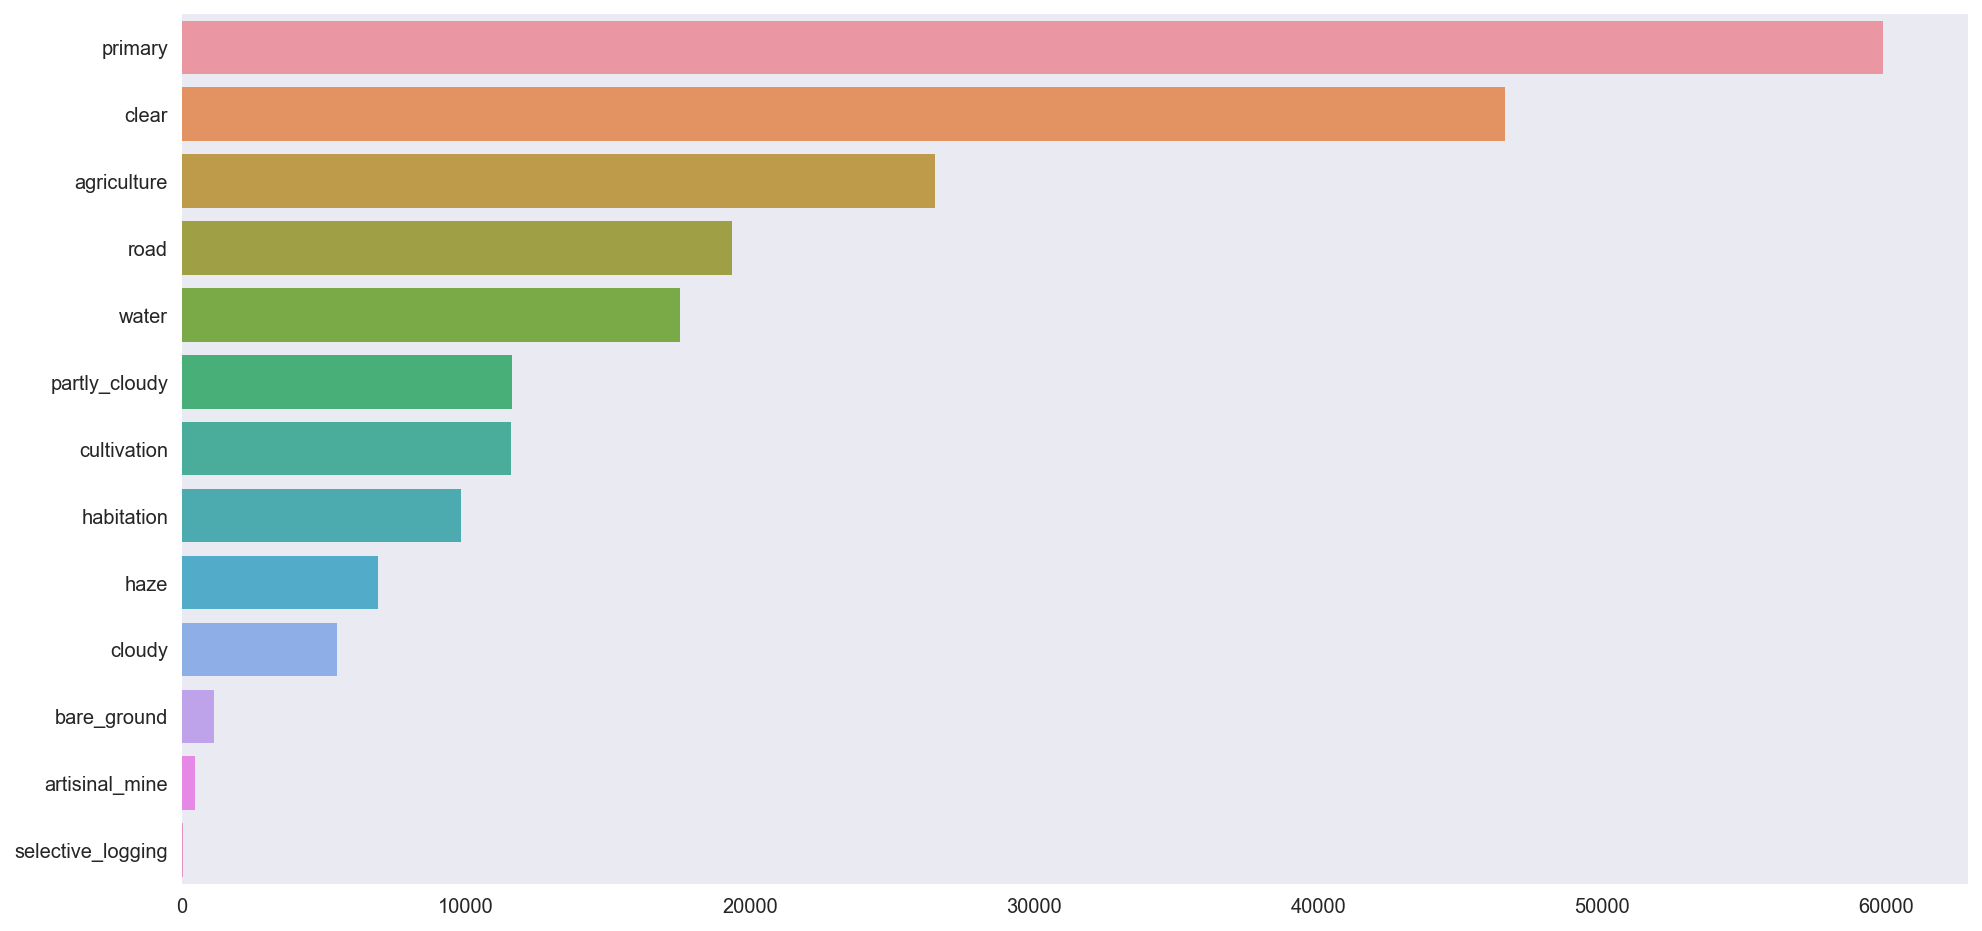

In [23]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

If there is a lot of `primary` and `clear` tags, this final dataset may be legit...

And save it to a submission file

In [24]:
final_df.to_csv('../submission_file.csv', index=False)
classifier.close()

That's it, we're done!